In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import numpy as np
from vbem_niw import *
from data_bouncingball import *
from plots import *
import time

from torch.distributions.dirichlet import Dirichlet

In [2]:
num_seqs = 5
T = 150 ## time series length
K = 4 ## number of clusters (directions)
D = 2 ## dimenison of coordinates
bound =12
noise_ratio = 0.1

## training parameters
iterations = 30

In [3]:
# """
# By setting the prior of mean of clusters as torch.FloatTensor([[1, 1], [1, -1], [-1, -1], [-1, 1]]) * (1 / math.sqrt(2)), the state name (1, 2, 3, 4) always indicates the following velocity direction :
#    1      2           3     4
#   _                         _
#   /|     \           /     |\
#  /        \         /        \
# /         _\|     |/_         \

# 1 to 2    2 to 1   3 to 2    4 to 3
# 1 to 4    2 to 3   3 to 4    4 to 1
# """

## visualization of an example trajectory
# disp, direction_state, mus, covs, A, pi, position = generate_seq(T, K, bound, noise_ratio,  dt=1.0, radius=0.0)
# plot_trjectory(position, disp, fs=4)

In [4]:
Disps, Zs, As_true, Mus_true, Covs, Pis = generate_seqs(num_seqs, T, K, D, bound, noise_ratio,  dt=1.0, radius=0.0)    

In [5]:
Covs_pred = torch.zeros((num_seqs, K, D, D))
Mus_pred = torch.zeros((num_seqs, K, D))
As_pred = torch.zeros((num_seqs, K, K))
## Train multiple models which don't share parameters
for s in range(num_seqs):
    Y = Disps[s]
    alpha_init_0, alpha_trans_0, ms_0, betas_0, nus_0, Ws_0 = init_priors(Y, T, K, D)
    alpha_init, alpha_trans, ms, betas, nus, Ws = init_posterior(Y, T, K, D)
#     alpha_init_0, alpha_trans_0, ms_0, betas_0, nus_0, Ws_0, alpha_init, alpha_trans, ms, betas, nus, Ws = pirors(Y, T, D, K)
    epoch_elbos = []
    for i in range(iterations):
        ## VBE step
        log_gammas, log_eta = vbE_step(alpha_init, alpha_trans, ms, betas, nus, Ws, Y, T, D, K)
#         log_gammas, log_eta = vbE_step(alpha_init, alpha_trans, nus, Ws, ms, betas, Y, T, D, K)

        N_ks, Y_ks, S_ks = stats(log_gammas, Y, D, K)
        ## VBM step
#         alpha_init, alpha_trans, ms, betas, nus, Ws, cov_ks = vbM_step(log_eta, alpha_init_0, alpha_trans_0, ms_0, betas_0, nus_0, Ws_0, N_ks, Y_ks, S_ks, T, D, K)
        alpha_init, alpha_trans, nus, Ws, ms, betas, cov_ks = vbM_step(log_eta, alpha_init_0, alpha_trans_0, nus_0, Ws_0, ms_0, betas_0, N_ks, Y_ks, S_ks, T, D, K)
#         epoch_elbo = elbo(log_gammas, log_eta, alpha_init_0, alpha_trans_0, 6.0, Ws_0[0], ms_0, 1.0, N_ks, Y_ks, S_ks, alpha_init, alpha_trans, nus, Ws, ms, betas, Y, T, D, K)
#         epoch_elbos.append(epoch_elbo)
#         print('Iteration:%d, ELBO:%f' % ((i+1), epoch_elbo))
    Covs_pred[s] = cov_ks ## mean of inverse wishart
    Mus_pred[s] = ms ## mean of gaussian
    As_pred[s] = Dirichlet(alpha_trans).sample()
    print('training completed_0 : %d' % (s))

training completed_0 : 0
training completed_0 : 1
training completed_0 : 2
training completed_0 : 3
training completed_0 : 4


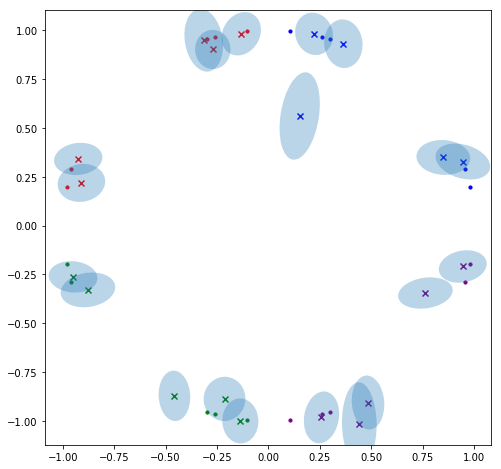

In [6]:
plot_results_clusters(Mus_true, Mus_pred, Covs_pred, K, num_seqs, fs=8.0)

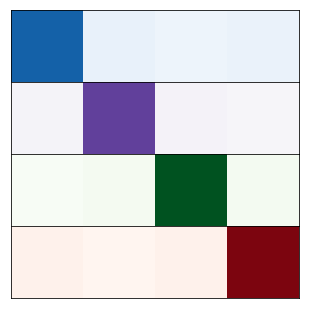

In [7]:
## true transition
plot_results_transition(As_true, vmax=1.0, fs=4.0)

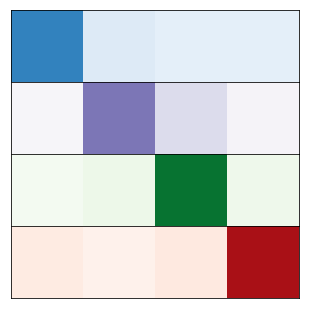

In [8]:
## sample from variational distribution
plot_results_transition(As_pred, vmax=1.0, fs=4.0)

In [9]:
a = torch.arange(9).view(3,3).float()

In [10]:
a.repeat(3,1,1)

tensor([[[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]],

        [[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]],

        [[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]]])